Sobel Gradient

image shape: (720, 1280, 3)
gray shape:  (720, 1280)


Text(0.5, 1.0, 'Gray Image')

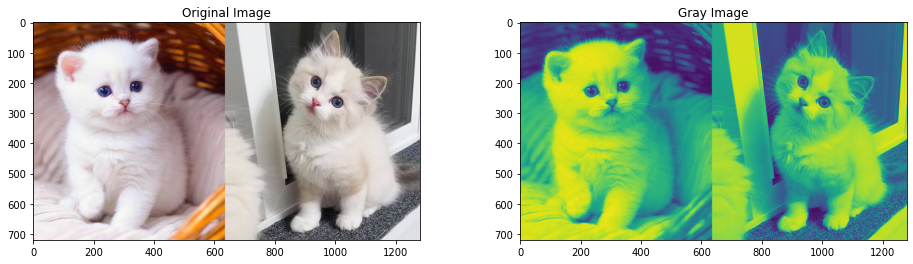

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = plt.imread('/content/drive/MyDrive/Object Detection AIVN 2023/Week 1/cat.jpg', cv2.IMREAD_UNCHANGED)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('image shape:', img.shape)
print('gray shape: ', gray.shape)

plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(gray)
plt.title('Gray Image')

gray shape: (720, 1280)
gx shape: (720, 1280)
gy shape: (720, 1280)


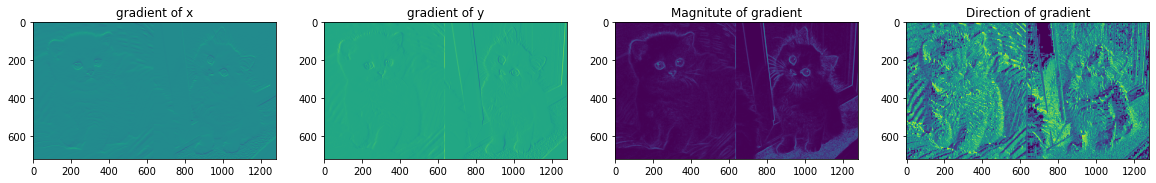

In [ ]:
# Calculate gradient gx, gy
gx = cv2.Sobel(gray, cv2.CV_32F, dx=0, dy=1, ksize=3)
gy = cv2.Sobel(gray, cv2.CV_32F, dx=1, dy=0, ksize=3)

print('gray shape: {}'.format(gray.shape))
print('gx shape: {}'.format(gx.shape))
print('gy shape: {}'.format(gy.shape))

# Python Calculate gradient magnitude and direction ( in degrees )
g, theta = cv2.cartToPolar(gx, gy, angleInDegrees=True)

w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gx)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gy)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(g)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(theta)


Example of CNN Object Detetection


In [ ]:
import imutils
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [ ]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image


In [ ]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import time
import cv2


image = "/content/drive/MyDrive/Object Detection AIVN 2023/Week 1/cat.jpg"
size = (200, 150)
min_conf = 0.9
visualize = -1
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = size
INPUT_SIZE = (224, 224)

In [ ]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(image)
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...


In [ ]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [ ]:
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))
  
  # check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if visualize > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)
			# show the visualization and current ROI
			cv2_imshow(clone)
			cv2_imshow(roiOrig)
			cv2_imshow(0)

In [ ]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 0.41022 seconds
[INFO] classifying ROIs...
12/12 [==============================] - 59s 5s/step
[INFO] classifying ROIs took 83.17146 seconds
35363/35363 [==============================] - 0s 0us/step


In [ ]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= min_conf:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]
		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'Persian_cat'


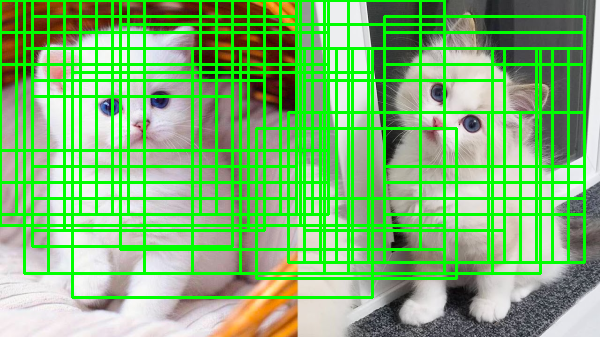

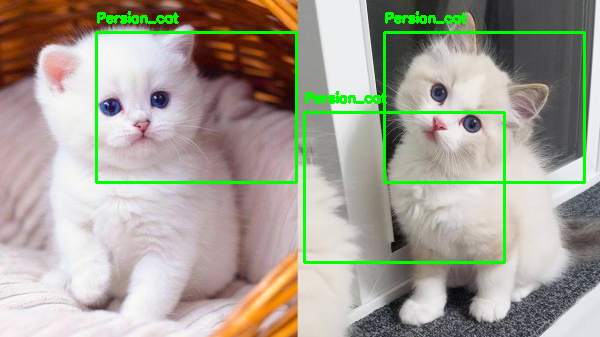

In [ ]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	cv2_imshow(clone)
	clone = orig.copy()
 	# extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)
	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	# show the output after apply non-maxima suppression
	cv2_imshow(clone)


Alex Net

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def AlexNet():
  inp = layers.Input((224, 224, 3))
  x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Conv2D(256, 5, 1, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(256, 3, 1, activation='relu')(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inp, outputs=x)

  return model

model = AlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 256)      1024  

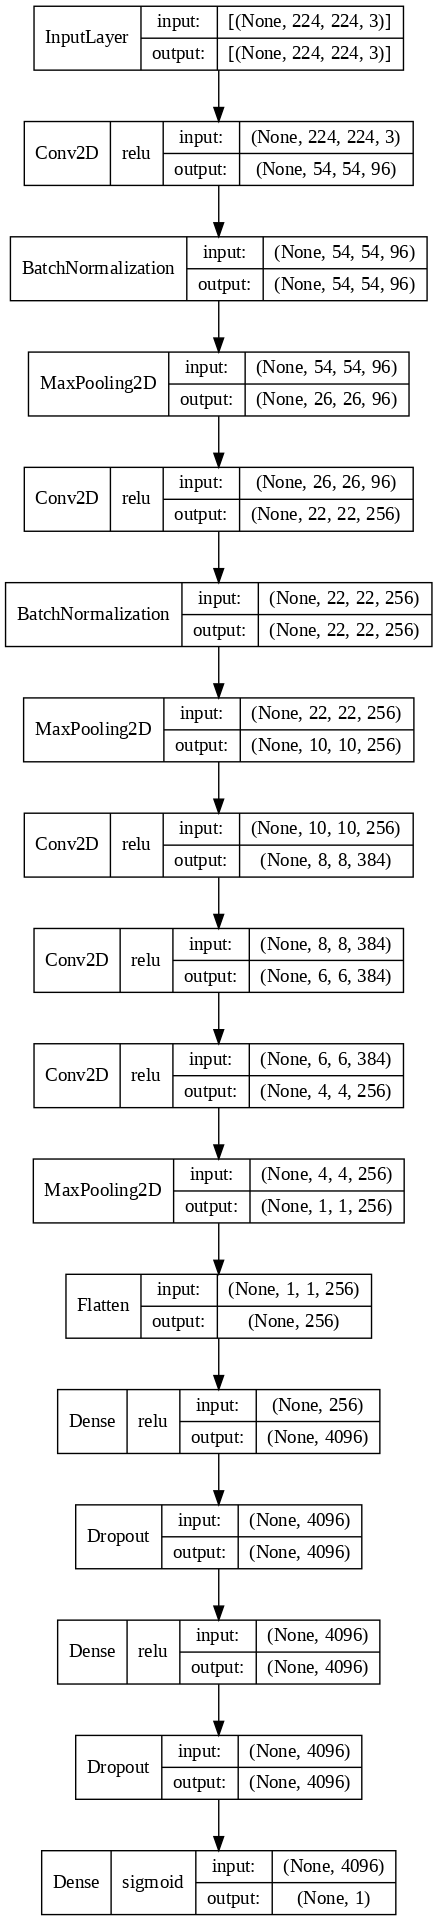

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

Augmentation Tecniques

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
import keras


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


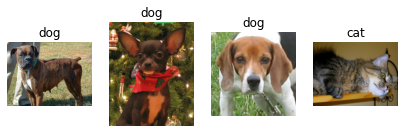

In [ ]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label));

Resize and rescale 

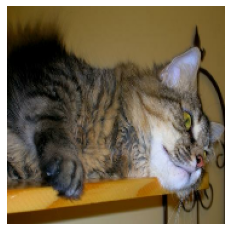

In [ ]:
IMG_SIZE = 180

resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);


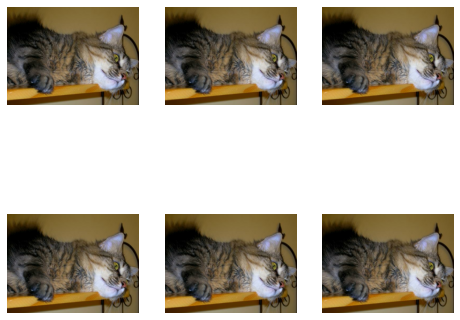

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")